This is a segmentation model using data from hubmap kidney segmentation competition from Kaggle. The model is trained on a dataset created before the update of the train/test dataset of the competition (thus some images are shifted and/or inaccurate). 

The dataset used is created tiling each full image in 1024x1024 tiles partially overlapping, i.e. the possible coordinates (in image pixels) of the top rightmost corner of the tiles are (512n,512m) with n,m integers. 

The dataset is made of tfrecord files to improve TPU performance.

The architecture choosed to experiment with is based on the Unet architecture and implement attention through convolutional block attention modules and a modification of them to get an attention mechanism between the "encoder" and the "decoder" of the Unet. 

The code is written to optimize performance with TPUs.

In [1]:
#Loading modules
import tensorflow as tf 
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Reshape, TimeDistributed, Permute, Lambda, GlobalAveragePooling2D, Conv2DTranspose,  MaxPooling2D
from tensorflow.keras.layers import Dense, Concatenate, Flatten,Dropout,  BatchNormalization, GlobalMaxPooling2D,GaussianNoise,SeparableConv2D
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.utils import plot_model
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import gc
from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

In [2]:
#TPU initialization
TPU=True

if TPU:

    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
     strategy = tf.distribute.MirroredStrategy()

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
#build GCS paths

GCS_PATH = KaggleDatasets().get_gcs_path('hubmap-1024-with-shifts')

print(GCS_PATH)
train_paths=[]
for i in range(19):
    if i<10:
      train_paths.append('Cortex-1024-000'+str(i)+'-of-0020.tfrecord')
      train_paths.append('Cortex-hshifted-1024-000'+str(i)+'-of-0020.tfrecord')
      train_paths.append('Cortex-vshifted-1024-000'+str(i)+'-of-0020.tfrecord')
      train_paths.append('Cortex-hvshifted-1024-000'+str(i)+'-of-0020.tfrecord')
    else: 
      train_paths.append('Cortex-1024-00'+str(i)+'-of-0020.tfrecord')
      train_paths.append('Cortex-hshifted-1024-00'+str(i)+'-of-0020.tfrecord')
      train_paths.append('Cortex-vshifted-1024-00'+str(i)+'-of-0020.tfrecord')
      train_paths.append('Cortex-hvshifted-1024-00'+str(i)+'-of-0020.tfrecord')

val_paths=['Cortex-hshifted-1024-0019-of-0020.tfrecord','Cortex-vshifted-1024-0019-of-0020.tfrecord',
           'Cortex-hvshifted-1024-0019-of-0020.tfrecord','Cortex-1024-0019-of-0020.tfrecord']

#build corresponding GCS file paths (only works in Kaggle)
def build_gcs_paths( bucket_path, local_file_paths):
    gcs_paths = []
    for file_path in local_file_paths:
        file_name = file_path.split('/')
        file_name = file_name[-1]
        gcs_name = bucket_path+'/'+file_name
        gcs_paths = np.append(gcs_paths,gcs_name)
    return gcs_paths

train_GCS_files=build_gcs_paths(GCS_PATH,train_paths)
val_GCS_files=build_gcs_paths(GCS_PATH,val_paths)
print(train_GCS_files)
print(val_GCS_files)

gs://kds-4c93d01180fd26a35f5d85eeba75cffae6e29089b570885dbaf80c18
['gs://kds-4c93d01180fd26a35f5d85eeba75cffae6e29089b570885dbaf80c18/Cortex-1024-0000-of-0020.tfrecord'
 'gs://kds-4c93d01180fd26a35f5d85eeba75cffae6e29089b570885dbaf80c18/Cortex-hshifted-1024-0000-of-0020.tfrecord'
 'gs://kds-4c93d01180fd26a35f5d85eeba75cffae6e29089b570885dbaf80c18/Cortex-vshifted-1024-0000-of-0020.tfrecord'
 'gs://kds-4c93d01180fd26a35f5d85eeba75cffae6e29089b570885dbaf80c18/Cortex-hvshifted-1024-0000-of-0020.tfrecord'
 'gs://kds-4c93d01180fd26a35f5d85eeba75cffae6e29089b570885dbaf80c18/Cortex-1024-0001-of-0020.tfrecord'
 'gs://kds-4c93d01180fd26a35f5d85eeba75cffae6e29089b570885dbaf80c18/Cortex-hshifted-1024-0001-of-0020.tfrecord'
 'gs://kds-4c93d01180fd26a35f5d85eeba75cffae6e29089b570885dbaf80c18/Cortex-vshifted-1024-0001-of-0020.tfrecord'
 'gs://kds-4c93d01180fd26a35f5d85eeba75cffae6e29089b570885dbaf80c18/Cortex-hvshifted-1024-0001-of-0020.tfrecord'
 'gs://kds-4c93d01180fd26a35f5d85eeba75cffae6e29089b57

In [4]:
# Create a dictionary describing the features.
image_feature_description2 = {
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'mask/encoded': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function2(example_proto, TILE_SIZE, NUM_CHANNELS):
  # Parse the input tf.Example proto using the dictionary above.
    single_example = tf.io.parse_single_example(example_proto, image_feature_description2)
    
    img_bytes =  tf.image.decode_jpeg(single_example['image/encoded'], channels=3)
   
    img_array = tf.reshape( img_bytes, (1024, 1024, 3))
    img_array = tf.cast(img_array, tf.float32) / 255.0
    
    mask_bytes = tf.image.decode_png(single_example['mask/encoded'], channels=1)
    mask = tf.reshape(mask_bytes, (1024,1024,1))
    
    mask = tf.cast(mask, tf.float32)
    

   
    return img_array, mask

def read_tf_dataset2(storage_file_path, TILE_SIZE, NUM_CHANNELS):
    encoded_image_dataset = tf.data.TFRecordDataset(storage_file_path)
    #ds = ds.map(lambda x: fun(x, my_arg))
    
    #parsed_image_dataset = encoded_image_dataset.map(_parse_image_function(TILE_SIZE=TILE_SIZE, NUM_CHANNELS=NUM_CHANNELS))
    parsed_image_dataset = encoded_image_dataset.map(lambda x: _parse_image_function2(x,TILE_SIZE=1024, NUM_CHANNELS=3))
    return parsed_image_dataset



In [5]:
#Create train and validation dataset
with strategy.scope():           
    batch_size = 32
    train_dataset = read_tf_dataset2(train_GCS_files,1024,3)
    validation_dataset = read_tf_dataset2(val_GCS_files,1024,3)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True).shuffle(100).cache().prefetch(buffer_size=AUTOTUNE)
        
    
        #validation_dataset = read_dataset(gcs_validation_cropped_files)
    validation_dataset = validation_dataset.batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)




**Visualize some tiles**


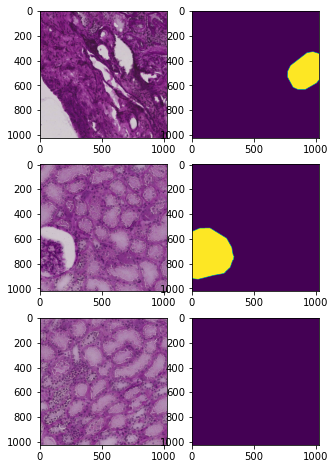

In [6]:
train_image = []
train_mask =[]
for image, mask in train_dataset.take(1):
    train_image, train_mask = image, mask
    
   
fig, axs=plt.subplots(3,2,figsize=(5,8))
axs[0,0].imshow(train_image[0])
axs[0,1].imshow(train_mask[0,:,:,0])
axs[1,0].imshow(train_image[1])
axs[1,1].imshow(train_mask[1,:,:,0])
axs[2,0].imshow(train_image[2])
axs[2,1].imshow(train_mask[2,:,:,0])    


In [7]:
#Data augmentation using keras experimental preprocessing layers and the map function for tf dataset
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomRotation(0.05,fill_mode="reflect",interpolation="bilinear"),
tf.keras.layers.experimental.preprocessing.RandomCrop(512, 512),
tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
])

image_only_augmentation=tf.keras.Sequential([
    Lambda(lambda x: tf.image.random_brightness(x, 0.25)),
    Lambda(lambda x: tf.image.random_contrast(x, 0.7,1.3)),
    Lambda(lambda x: tf.image.random_hue( x, 0.25)),
    Lambda(lambda x: tf.image.random_saturation(x, 0.7,1.3)),
    GaussianNoise(0.2), 

] )


val_cropping = tf.keras.Sequential([
tf.keras.layers.Cropping2D(cropping=256),

])



train_dataset =train_dataset.map(lambda x, y: tf.split(data_augmentation(Concatenate(axis=-1)([x,y]), training=True), (3,1), axis=-1), 
                num_parallel_calls=AUTOTUNE)

train_dataset=train_dataset.map(lambda x, y : (image_only_augmentation(x,training=True),y))
validation_dataset=validation_dataset.map(lambda x, y: tf.split(val_cropping(Concatenate(axis=-1)([x,y]), training=True), (3,1), axis=-1), 
                num_parallel_calls=AUTOTUNE)




**Visualize some tiles after augmentation**

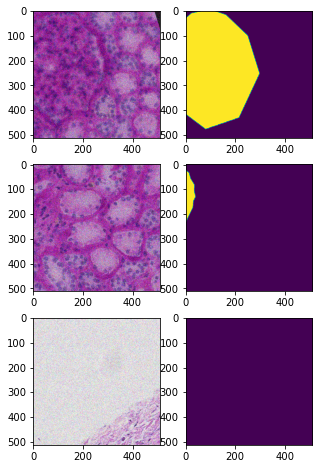

In [8]:
train_image = []
train_mask =[]
for image, mask in train_dataset.take(1):
    train_image, train_mask = image, mask
    
   
fig, axs=plt.subplots(3,2,figsize=(5,8))
axs[0,0].imshow(train_image[0])
axs[0,1].imshow(train_mask[0,:,:,0])
axs[1,0].imshow(train_image[1])
axs[1,1].imshow(train_mask[1,:,:,0])
axs[2,0].imshow(train_image[2])
axs[2,1].imshow(train_mask[2,:,:,0])

In [9]:
#model architecture
ACT=tf.keras.layers.ELU(alpha=0.1)

#Multi linear perceptron to use in the CBAM module 

def build_MLP(filters_size=64, reduction_factor=2):
    inputs=Input(shape=filters_size)
    dense=Dense(filters_size//2**(reduction_factor), activation=ACT)(inputs)
    dense=BatchNormalization()(dense)
    dense=Dense(filters_size, activation='sigmoid')(dense)
    dense=Reshape((1,1,filters_size))(dense)
    MLP=Model(inputs=inputs, outputs=dense)
    return MLP

#Implementation of convolutional block attention module from the paper https://arxiv.org/abs/1807.06521

def CBAM(inputs, filters_size=32,reduction_factor=2):
    Avg=GlobalAveragePooling2D()(inputs)
    Max=GlobalMaxPooling2D()(inputs)
    MLP=build_MLP(filters_size=filters_size,reduction_factor=reduction_factor)
    Max=MLP(Max)
    Avg=MLP(Avg)
    channel_attention=keras.activations.sigmoid(Avg+Max)
    channel_conditioned=tf.math.multiply(inputs, channel_attention)
    channel_average=Lambda(lambda x: keras.backend.mean(x, axis=-1,  keepdims=True))(channel_conditioned)
    channel_max=Lambda(lambda x: keras.backend.max(x, axis=-1,  keepdims=True))(channel_conditioned)
    spatial_reduction=Concatenate(axis=-1)([channel_average, channel_max])
    spatial_reduction=BatchNormalization()(spatial_reduction)
    spatial_attention=Conv2D(filters=filters_size, kernel_size=11,padding='same', activation='sigmoid')(spatial_reduction)
    spatial_conditioned=tf.math.multiply(channel_conditioned, spatial_attention)
    
    return spatial_conditioned

#A modification of the CBAM module to implement an attention mechanism between the "encoder" and "decoder" part of 
# the Unet architecture. It multiplies a "value" input with attention computed on a "query"

def EDCBAM(value,query, filters_size=64, reduction_factor=2):
    Avg=GlobalAveragePooling2D()(query)
    Max=GlobalMaxPooling2D()(query)
    MLP=build_MLP(filters_size=filters_size, reduction_factor=reduction_factor)
    Max=MLP(Max)
    Avg=MLP(Avg)
    channel_attention=keras.activations.sigmoid(Avg+Max)
    channel_conditioned=tf.math.multiply(value, channel_attention)
    channel_average=Lambda(lambda x: keras.backend.mean(x, axis=-1,  keepdims=True))(query)
    channel_max=Lambda(lambda x: keras.backend.max(x, axis=-1,  keepdims=True))(query)
    spatial_reduction=Concatenate(axis=-1)([channel_average, channel_max])
    spatial_reduction=BatchNormalization()(spatial_reduction)
    spatial_attention=Conv2D(filters=filters_size, kernel_size=11,padding='same', activation='sigmoid')(spatial_reduction)
    spatial_conditioned=tf.math.multiply(channel_conditioned, spatial_attention)
    
    return spatial_conditioned


#Skip-connection block that reduce each spatial input dimension by a factor of 2
def downsampling_block(inputs,filters=64,attention_reduction_factor=2,dilations=(1,1,1), skip_block=True,dropout=0):
    skip=Conv2D(filters=filters, kernel_size=3, activation=ACT, padding='same')(inputs)
    skip=SpatialDropout2D(dropout)(skip)
    attention=CBAM(skip,filters_size=filters, reduction_factor=attention_reduction_factor)

    if skip_block:
        down=BatchNormalization()(skip+attention)   
        down=Conv2D(filters=filters, kernel_size=3, activation=ACT,dilation_rate=dilations[1], padding='same')(down)
        attention=CBAM(down,filters_size=filters, reduction_factor=attention_reduction_factor)
        down=BatchNormalization()(down+attention)   
        down=Conv2D(filters=filters, kernel_size=3, activation=ACT, dilation_rate=dilations[2], padding='same')(down)
        downsampled=MaxPooling2D(pool_size=2)(down+attention+skip)
    else:
        downsampled=MaxPooling2D(pool_size=2)(attention+skip)

    downsampled=Dropout(dropout)(downsampled)
    downsampled=BatchNormalization()(downsampled)
    
    return downsampled


#Skip-connection block that increase each spatial input dimension by a factor of 2. 
#Using transposed convolutions because Upsampling layers are currently not supported with TPU
def upsampling_block(inputs,encoded,filters=64,attention_reduction_factor=2,dilations=(1,1,1), skip_block=True, dropout=0):
    #use kernel_size divisible by strides
    skip=Conv2D(filters=filters, kernel_size=3, activation=ACT, padding='same')(inputs)
    skip=SpatialDropout2D(dropout)(skip)
    attention=CBAM(skip,filters_size=filters, reduction_factor=attention_reduction_factor)

    if skip_block:
        up=BatchNormalization()(skip+attention)
        up=Conv2D(filters=filters, kernel_size=3, activation=ACT,dilation_rate=dilations[0], padding='same')(up)
        attention=CBAM(up,filters_size=filters, reduction_factor=attention_reduction_factor)
        up=BatchNormalization()(up+attention)    
        up=Conv2D(filters=filters, kernel_size=3, activation=ACT,  dilation_rate=dilations[1], padding='same')(up)
        attention=CBAM(up,filters_size=filters, reduction_factor=attention_reduction_factor)
        up=BatchNormalization()(up+attention)   
        up=Conv2D(filters=filters, kernel_size=3, activation=ACT,  dilation_rate=dilations[2], padding='same')(up)
        attention=CBAM(up,filters_size=filters, reduction_factor=attention_reduction_factor)
        up=BatchNormalization()(up+attention+skip)
    else: 
        up=BatchNormalization()(attention+skip)

    up=Conv2DTranspose(filters=filters, kernel_size=2, strides=2, activation=ACT, padding='same')(up)
    encoded=Conv2D(filters=filters, kernel_size=1, activation=ACT, padding='same')(encoded)
    encoded_attention=EDCBAM(encoded,up, filters_size=filters, reduction_factor=attention_reduction_factor)
    up=Concatenate(axis=-1)([up,encoded+encoded_attention])
    upsampled=BatchNormalization()(up)
    return upsampled

#Block increasing each spatial dimension by 2^upscale_factor. Used to make more use of information at different scales. 
def upscale(reduced,upscale_factor, filters):
    upscaled=reduced
    for i in range(upscale_factor):
      upscaled=Conv2DTranspose(filters=filters, kernel_size=2, strides=2, activation=ACT,padding='same')(upscaled)
    upscaled=BatchNormalization()(upscaled)
    return upscaled


#Function to build the model. It uses a Unet-like architecture. Some skip blocks are not used because of hardware limitations.

def build_attentive_Unet():
    Inp=Input(shape=(512,512,3))
    unred=Conv2D(filters=16,kernel_size=3, activation=ACT, padding='same')(Inp)
    reduced1=downsampling_block(unred, filters=32,attention_reduction_factor=1)
    reduced2=downsampling_block(reduced1,filters=64,attention_reduction_factor=1)
    reduced3=downsampling_block(reduced2,filters=128,attention_reduction_factor=2)
    reduced4=downsampling_block(reduced3,filters=256,attention_reduction_factor=3)
    reduced5=downsampling_block(reduced4,filters=512,attention_reduction_factor=4, dropout=0.2)
    reduced6=downsampling_block(reduced5,filters=1024,attention_reduction_factor=5, dropout=0.5)
    upsampled1=upsampling_block(reduced6,reduced5,filters=256,attention_reduction_factor=3)
    upsampled2=upsampling_block(upsampled1,reduced4,filters=128,attention_reduction_factor=2,skip_block=False)
    upsampled3=upsampling_block(upsampled2,reduced3,filters=64,attention_reduction_factor=1,skip_block=False)
    upsampled4=upsampling_block(upsampled3,reduced2,filters=32,attention_reduction_factor=1,skip_block=False)
    upsampled5=upsampling_block(upsampled4,reduced1,filters=16,attention_reduction_factor=0,skip_block=False)
    upsampled6=upsampling_block(upsampled5,unred,filters=8,attention_reduction_factor=0,skip_block=False)

    upscaled1=upscale(reduced1, 1, 8)
    upscaled2=upscale(reduced2,2, 8)
    upscaled3=upscale(reduced3, 3, 8)
    upscaled4=upscale(reduced4, 4, 8)
    upscaled5=upscale(reduced5, 5, 8)
    upscaled6=upscale(reduced6, 6,8)

    scales=Concatenate(axis=-1)([upscaled1, upscaled2,upscaled3, upscaled4, upscaled5,upscaled6, upsampled6])

    processed=Conv2D(filters=128,kernel_size=3, activation=ACT, padding='same')(scales)
    attention=CBAM(processed,filters_size=128,reduction_factor=2)
    processed=BatchNormalization()(processed+attention)
       
    segmented=Conv2D(filters=1, kernel_size=7, activation='sigmoid',padding='same')(processed)
    
    model=Model(inputs=Inp, outputs=segmented)
    
    return model

with strategy.scope():  
    attentive_Unet=build_attentive_Unet()
attentive_Unet.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 4640        conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 512, 512, 32) 0           conv2d_1[0][0]                   
___________________________________________________________________________________________

**Plot of the architecture**

In [10]:
plot_model(attentive_Unet, to_file='model.png',show_shapes=True, show_layer_names=True)

In [11]:
#loss functions and metrics
def tversky_coeff(y_true, y_pred, smooth=1, alpha=0.8):
 
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def focal_tversky_loss(y_true, y_pred, gamma=1.):
    tv = tversky_coeff(y_true, y_pred)
    return K.pow((1 - tv), gamma)

with strategy.scope():
    def dice_coeff(y_true, y_pred):
        _epsilon = 10 ** -7
        intersections = tf.reduce_sum(y_true * y_pred)
        unions = tf.reduce_sum(y_true + y_pred)
        dice_scores = (2.0 * intersections + _epsilon) / (unions + _epsilon)
        return dice_scores
    
    def dice_score(y_true, y_pred):
        _epsilon = 10 ** -7
        intersections=tf.reduce_sum(tf.math.round(y_pred)*y_true)
        unions = tf.reduce_sum(y_true + tf.math.round(y_pred))
        dice_score= (2.0 * intersections + _epsilon) / (unions + _epsilon)        
        return dice_score

    def bce_dice_loss(y_true, y_pred):
        loss =(1 - dice_coeff(y_true, y_pred)) +tf.keras.losses.binary_crossentropy(y_true,y_pred)
        return loss
    
    def bce_focal_tversky(y_true, y_pred, c=0):
        loss=c*tf.keras.losses.binary_crossentropy(y_true,y_pred)+focal_tversky_loss(y_true, y_pred)
        return loss

loaded weights
Epoch 1/10
312/312 [==============================] - 711s 2s/step - dice_coeff: 0.5960 - dice_score: 0.5961 - loss: 0.3674 - val_dice_coeff: 0.6281 - val_dice_score: 0.7442 - val_loss: 0.2554
Epoch 2/10
312/312 [==============================] - 658s 2s/step - dice_coeff: 0.5890 - dice_score: 0.5890 - loss: 0.3737 - val_dice_coeff: 0.6275 - val_dice_score: 0.7440 - val_loss: 0.2575
Epoch 3/10
312/312 [==============================] - 658s 2s/step - dice_coeff: 0.5934 - dice_score: 0.5934 - loss: 0.3689 - val_dice_coeff: 0.6319 - val_dice_score: 0.7489 - val_loss: 0.2449
Epoch 4/10
312/312 [==============================] - 659s 2s/step - dice_coeff: 0.5960 - dice_score: 0.5960 - loss: 0.3677 - val_dice_coeff: 0.6158 - val_dice_score: 0.7240 - val_loss: 0.2800
Epoch 5/10
312/312 [==============================] - 659s 2s/step - dice_coeff: 0.5948 - dice_score: 0.5948 - loss: 0.3660 - val_dice_coeff: 0.6375 - val_dice_score: 0.7469 - val_loss: 0.2401
Epoch 6/10
312/312 [

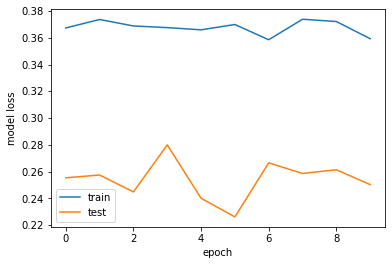

In [12]:
call=[tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Kaggle/Hubmap/checkpoint',
    monitor="val_loss",
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
    options=None),
      
       tf.keras.callbacks.CSVLogger('log.csv'),
     ] 

continue_training=True

if continue_training:
  attentive_Unet.load_weights('../input/hubmap-segmentation/AttUnet.h5')
  print('loaded weights')

with strategy.scope():   
    attentive_Unet.compile(optimizer = tf.keras.optimizers.Nadam(lr =3e-6), loss =bce_focal_tversky, metrics=[dice_score, dice_coeff])
history=attentive_Unet.fit(train_dataset, epochs=10, validation_data=validation_dataset, verbose=1)

attentive_Unet.save_weights('AttUnet.h5', overwrite=True)

#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')          
plt.legend(['train', 'test'], loc='best')
plt.savefig('history.png')
plt.show()

**Visualize some predictions**

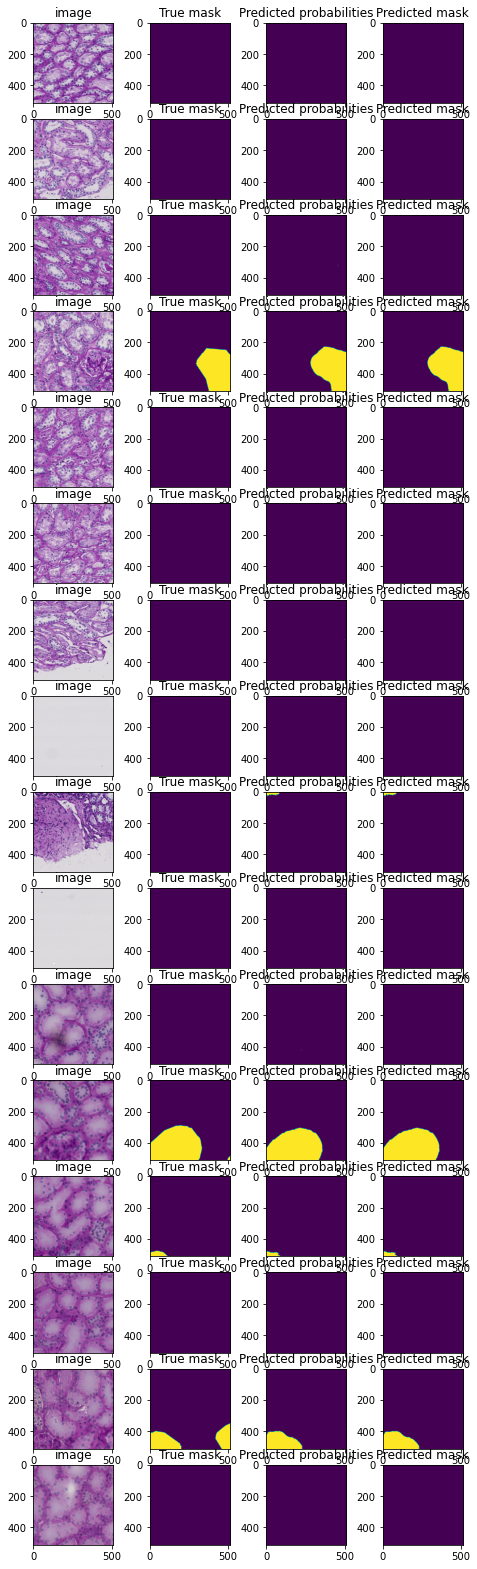

In [13]:
val_image = []
val_mask =[]
validation_dataset=validation_dataset.shuffle(buffer_size=300)
for image, mask in validation_dataset.take(1):
    val_image, val_mask = image, mask
    
predicted=attentive_Unet.predict(val_image) 
rounded=np.round(predicted)
fig, axs=plt.subplots(16,4, figsize=(8,28))
for i in range(16):
  axs[i,0].imshow(val_image.numpy()[i])
  axs[i,0].set_title('image')
  axs[i,1].imshow(val_mask.numpy()[i,:,:,0])
  axs[i,1].set_title('True mask')
  axs[i,2].imshow(predicted[i,:,:,0])
  axs[i,2].set_title('Predicted probabilities')
  axs[i,3].imshow(rounded[i,:,:,0])
  axs[i,3].set_title('Predicted mask')



plt.show()

